In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
N, D1, D2 = train_data.data.shape
#_, Nc = train_data.targets.shape
D = D1 * D2 
Nc = 10 # #classes
N, D1, D2, D, Nc
class MyModel(nn.Module):
    def __init__(self, D:int, Nc:int):
        super().__init__()
        self.flattern = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(D, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, Nc),
        )
    def forward(self,x):
        x = self.flattern(x)
        logits = self.net(x)
        return logits
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel(D, Nc).to(device)
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

Epochs = 3
loss_d = {'epoch': [], 'val':[], 'acc': []}
test_d = {'epoch': [], 'val':[], 'acc': []}
for i in range(Epochs):
    print(f'Epoch: {i}')
    size = len(train_dataloader.dataset)
    correct = 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 100 == 0:
            loss_v, current = loss.item(), (batch+1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    loss_d['epoch'].append(i)
    loss_d['val'].append(loss_v)
    correct /= size
    loss_d['acc'].append(correct)
    
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size 
        test_d['epoch'].append(i)
        test_d['val'].append(test_loss)
        test_d['acc'].append(correct)
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

MyModel(
  (flattern): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch: 0
loss: 2.300584  [   64/60000]
loss: 2.208334  [ 6464/60000]
loss: 2.007858  [12864/60000]
loss: 1.728981  [19264/60000]
loss: 1.296231  [25664/60000]
loss: 1.151382  [32064/60000]
loss: 1.060190  [38464/60000]
loss: 0.923122  [44864/60000]
loss: 0.923030  [51264/60000]
loss: 0.851487  [57664/60000]
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.834140

Epoch: 1
loss: 0.873822  [   64/60000]
loss: 0.874734  [ 6464/60000]
loss: 0.634417  [12864/60000]
loss: 0.821484  [19264/60000]
loss: 0.694137  [25664/60000]
loss: 0.668997  [32064/60000]
loss: 0.739252  [38464/60000]
loss: 0.713228  [44864/60000]
loss: 0.719522  [51264/60000]
loss: 0.659548  [57664/60000]
Test Error: 
 Accuracy: 77.0%, 

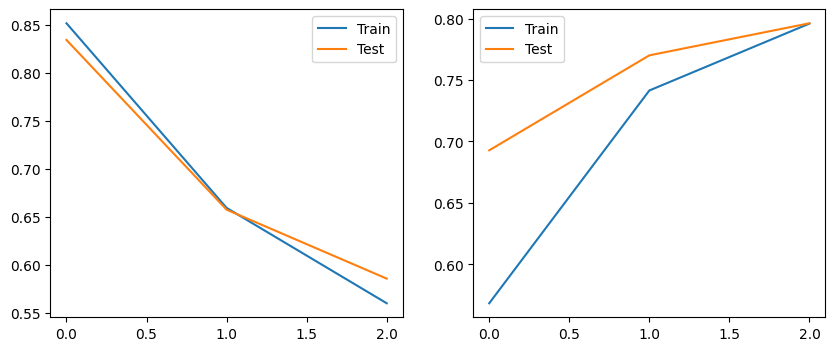

In [2]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(loss_d['epoch'], loss_d['val'], label='Train')
plt.plot(test_d['epoch'], test_d['val'], label='Test')
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_d['epoch'], loss_d['acc'], label='Train')
plt.plot(test_d['epoch'], test_d['acc'], label='Test')
plt.legend()
plt.show()

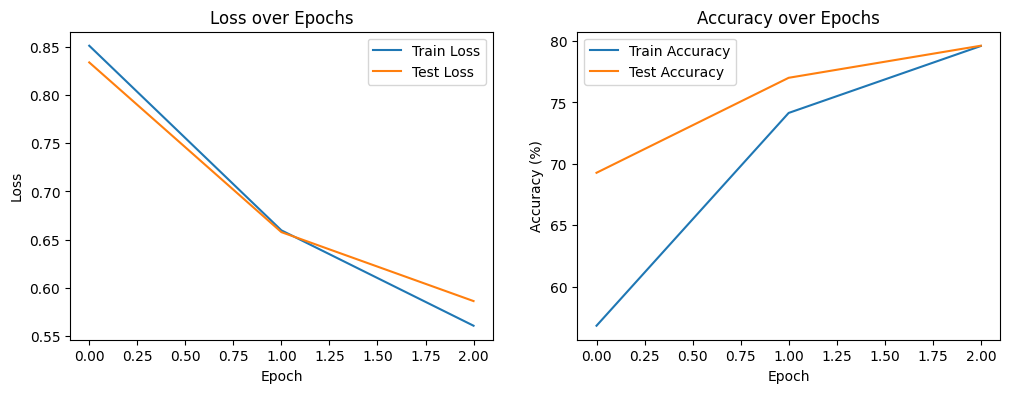

In [3]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
plt.figure(figsize=(12, 4))
# Train and Test Loss
plt.subplot(1, 2, 1)
plt.plot(loss_d['epoch'], loss_d['val'], label='Train Loss')
plt.plot(test_d['epoch'], test_d['val'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Train and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(loss_d['epoch'], [100 * acc for acc in loss_d['acc']], label='Train Accuracy')
plt.plot(test_d['epoch'], [100 * acc for acc in test_d['acc']], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()
